<center><h1>Jinyi_Ye_HW5</h1></center>
<br>
<br>

Name: Jinyi Ye
<br>
Github Username: angelayejinyi
<br>
USC ID: 1552624974

## 1. Decision Trees as Interpretable Models

Import packages

In [1]:
import numpy as np
import pandas as pd
from sklearn import tree

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

### (a) Obtain Data

Get the Accute Inamations Data Set, the first 6 columns are features, the last 2 columns are class labels.

In [2]:
df = pd.read_csv('../data/diagnosis.data', encoding='utf-16', sep='\t', 
                           names=['Temperature','Nausea','Lumbar Pain','Urine Pushing',
                                  'Micturition Pain','Urethra Burning','Inflammation','Nephritis'], header=None)
df = df.replace('\,','.',regex=True)
df

,Temperature,Nausea,Lumbar Pain,Urine Pushing,Micturition Pain,Urethra Burning,Inflammation,Nephritis
0,35.5,no,yes,no,no,no,no,no
1,35.9,no,no,yes,yes,yes,yes,no
2,35.9,no,yes,no,no,no,no,no
3,36.0,no,no,yes,yes,yes,yes,no
4,36.0,no,yes,no,no,no,no,no
...,...,...,...,...,...,...,...,...
115,41.4,no,yes,yes,no,yes,no,yes
116,41.5,no,no,no,no,no,no,no
117,41.5,yes,yes,no,yes,no,no,yes
118,41.5,no,yes,yes,no,yes,no,yes


### (b) Build a decision tree

We first convert the multi-label dataset to a multiclass dataset using the label powerset method.

In [3]:
from skmultilearn.problem_transform import LabelPowerset

# replace no with 0, yes with 1
df = df.replace('yes', 1)
df = df.replace('no', 0)

y = df.iloc[:,-3:-1].to_numpy()

# convert the multilabel dataset to a multiclass dataset using the label powerset method
lp = LabelPowerset()
y_lp = lp.transform(y)

# get the final dataset
df = df.iloc[:,:6]
df = df.assign(Class=y_lp)
df

,Temperature,Nausea,Lumbar Pain,Urine Pushing,Micturition Pain,Urethra Burning,Class
0,35.5,0,1,0,0,0,0
1,35.9,0,0,1,1,1,1
2,35.9,0,1,0,0,0,0
3,36.0,0,0,1,1,1,1
4,36.0,0,1,0,0,0,0
...,...,...,...,...,...,...,...
115,41.4,0,1,1,0,1,3
116,41.5,0,0,0,0,0,0
117,41.5,1,1,0,1,0,0
118,41.5,0,1,1,0,1,3


Next, we build a decision tree and plot it.

|--- feature_3 <= 0.50
|   |--- class: 0
|--- feature_3 >  0.50
|   |--- feature_5 <= 0.50
|   |   |--- class: 2
|   |--- feature_5 >  0.50
|   |   |--- feature_4 <= 0.50
|   |   |   |--- class: 3
|   |   |--- feature_4 >  0.50
|   |   |   |--- class: 1



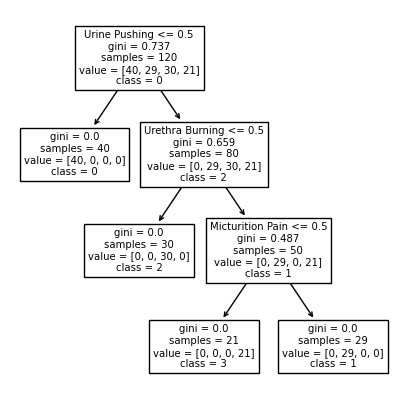

In [4]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

X = df.drop("Class", axis=1)
y = df["Class"]

clf = DecisionTreeClassifier()
clf.fit(X, y)

text_representation = tree.export_text(clf)
print(text_representation)

fig = plt.figure(figsize=(5,5))
_ = tree.plot_tree(clf, 
                   feature_names=X.columns,  
                   class_names=['0','1','2','3'],
                   filled=False)

### (c) Convert the decision rules into a set of IF-THEN rules

In [5]:
# https://www.kdnuggets.com/2017/05/simplifying-decision-tree-interpretation-decision-rules-python.html

# representing the decision tree model as a function
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
	"""
	Outputs a decision tree model as a Python function
	
	Parameters:
	-----------
	tree: decision tree model
		The decision tree to represent as a function
	feature_names: list
		The feature names of the dataset used for building the decision tree
	"""

	tree_ = tree.tree_
	feature_name = [
		feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
		for i in tree_.feature
	]
	print("def tree({}):".format(", ".join(feature_names)))

	def recurse(node, depth):
		indent = "  " * depth
		if tree_.feature[node] != _tree.TREE_UNDEFINED:
			name = feature_name[node]
			threshold = tree_.threshold[node]
			print("{}if {} <= {}:".format(indent, name, threshold))
			recurse(tree_.children_left[node], depth + 1)
			print("{}else:  # if {} > {}".format(indent, name, threshold))
			recurse(tree_.children_right[node], depth + 1)
		else:
			print("{}return {}".format(indent, tree_.value[node]))

	recurse(0, 1)

In [6]:
tree_to_code(clf, list(X.columns))

def tree(Temperature, Nausea, Lumbar Pain, Urine Pushing, Micturition Pain, Urethra Burning):
  if Urine Pushing <= 0.5:
    return [[40.  0.  0.  0.]]
  else:  # if Urine Pushing > 0.5
    if Urethra Burning <= 0.5:
      return [[ 0.  0. 30.  0.]]
    else:  # if Urethra Burning > 0.5
      if Micturition Pain <= 0.5:
        return [[ 0.  0.  0. 21.]]
      else:  # if Micturition Pain > 0.5
        return [[ 0. 29.  0.  0.]]


### (d) Use cost-complexity pruning to find a minimal decision tree and a set of decision rules with high interpretability.

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

# evaluate the accuracy of the classifier on the test data
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy before pruning:", accuracy)

# get the path of the decision tree nodes
path = clf.cost_complexity_pruning_path(X_train, y_train)

# extract the values of alpha (regularization parameter) and impurities
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# create a list of classifiers with different values of alpha
clfs = []
for ccp_alpha in ccp_alphas:
    clf_prune = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf_prune.fit(X_train, y_train)
    clfs.append(clf_prune)

# find the classifier with the highest accuracy on the test data
max_accuracy = 0
best_clf = None
for clf_prune in clfs:
    y_pred = clf_prune.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(clf_prune, "Accuracy:", accuracy)
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        best_clf = clf_prune

print("Accuracy after pruning:", max_accuracy)
print("Number of nodes in pruned tree:", best_clf.tree_.node_count)

text_representation = tree.export_text(best_clf)
print("\n")
print(text_representation)


Accuracy before pruning: 1.0
DecisionTreeClassifier(random_state=0) Accuracy: 1.0
DecisionTreeClassifier(ccp_alpha=0.19658119658119655, random_state=0) Accuracy: 0.7916666666666666
DecisionTreeClassifier(ccp_alpha=0.23463573463573462, random_state=0) Accuracy: 0.5416666666666666
DecisionTreeClassifier(ccp_alpha=0.30294105489418, random_state=0) Accuracy: 0.2916666666666667
Accuracy after pruning: 1.0
Number of nodes in pruned tree: 7


|--- feature_3 <= 0.50
|   |--- class: 0
|--- feature_3 >  0.50
|   |--- feature_5 <= 0.50
|   |   |--- class: 2
|   |--- feature_5 >  0.50
|   |   |--- feature_4 <= 0.50
|   |   |   |--- class: 3
|   |   |--- feature_4 >  0.50
|   |   |   |--- class: 1



After cost-complexity pruning with train-test split and a set of different alphas, we can conclude that the original tree has the best test accuracy with 7 nodes, which is already simple and interpretable. The three most important and distinguishable features are: Urine Pushing, Urethra Burning and Micturition Pain.

Here's how to interpret the results:

If Urine Pushing is "no", then the patient will have neither bladder inflammation nor pelvis nephritis.

If Urine Pushing is "yes", Urethra Burning is "no", then the patient will have bladder inflammation.

If Urine Pushing is "yes", Urethra Burning is "yes", Micturition Pain is "no", then the patient will have pelvis nephritis.

If Urine Pushing is "yes", Urethra Burning is "yes", Micturition Pain is "yes", then the patient will have both bladder inflammation and pelvis nephritis.

## 2. The LASSO and Boosting for Regression

### (a) Obtain Data

In [2]:
# read column names from the communities.names file
col_names = []
with open('../data/communities.names', 'r') as f:
    for line in f:
        if line.startswith('@attribute'):
            col_names.append(line.split()[1])

# read data from the Communities and Crime dataset
df = pd.read_csv('../data/communities.data', header=None, na_values=['?'])

# set column names
df.columns = col_names
df

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.90,0.5,0.32,0.14,0.20
1,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34,5.0,81440.0,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,42,95.0,6096.0,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,NaN,NaN,TempleTerracecity,10,0.01,0.40,0.10,0.87,0.12,...,0.01,0.28,0.05,NaN,NaN,NaN,NaN,0.00,NaN,0.09
1990,6,NaN,NaN,Seasidecity,10,0.05,0.96,0.46,0.28,0.83,...,0.02,0.37,0.20,NaN,NaN,NaN,NaN,0.00,NaN,0.45
1991,9,9.0,80070.0,Waterburytown,10,0.16,0.37,0.25,0.69,0.04,...,0.08,0.32,0.18,0.08,0.06,0.78,0.0,0.91,0.28,0.23
1992,25,17.0,72600.0,Walthamcity,10,0.08,0.51,0.06,0.87,0.22,...,0.03,0.38,0.33,0.02,0.02,0.79,0.0,0.22,0.18,0.19


### (b) Missing values

According to the dataset description, state, county, community, communityname and fold is non-predictive. So we only predict other variables based on KNN imputation.

In [3]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(df.iloc[:, 5:]), columns=col_names[5:])
df_imputed

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.060,0.040,0.900,0.5,0.32,0.140,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,0.124,0.050,0.832,0.5,0.00,0.244,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,0.172,0.038,0.680,0.7,0.00,0.294,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,0.088,0.016,0.802,0.4,0.00,0.106,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,0.044,0.020,0.708,0.0,0.00,0.332,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,0.35,0.30,...,0.01,0.28,0.05,0.042,0.024,0.752,0.3,0.00,0.130,0.09
1990,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,0.73,0.14,...,0.02,0.37,0.20,0.126,0.092,0.624,0.7,0.00,0.230,0.45
1991,0.16,0.37,0.25,0.69,0.04,0.25,0.35,0.50,0.31,0.54,...,0.08,0.32,0.18,0.080,0.060,0.780,0.0,0.91,0.280,0.23
1992,0.08,0.51,0.06,0.87,0.22,0.10,0.58,0.74,0.63,0.41,...,0.03,0.38,0.33,0.020,0.020,0.790,0.0,0.22,0.180,0.19


### (c) Plot a correlation matrix

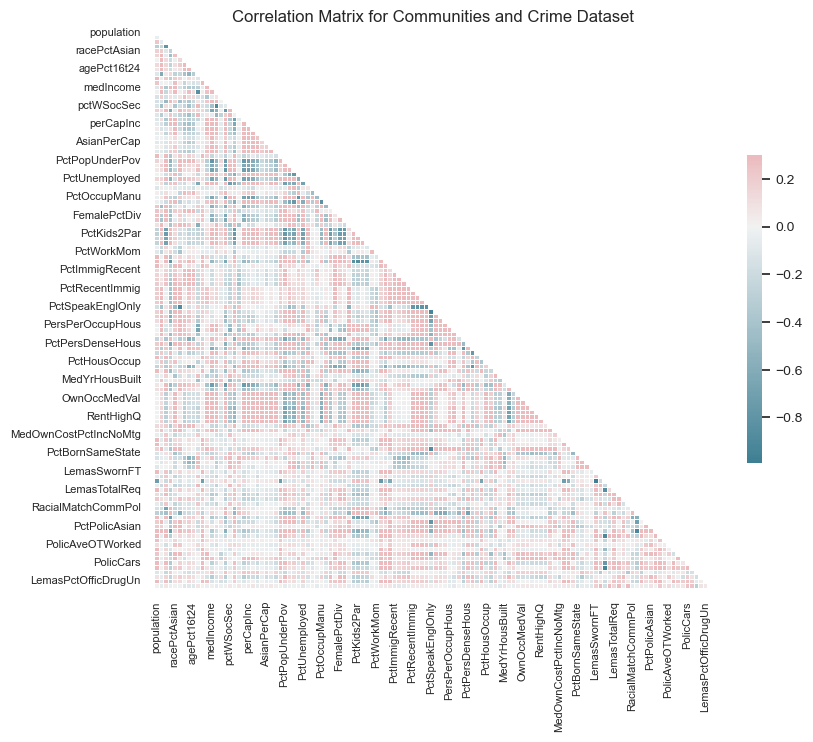

In [16]:
corr_matrix = df_imputed.iloc[:,:-1].corr()

sns.set(style="white")
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(9, 8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
heatmap = sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=8)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=8)

plt.title('Correlation Matrix for Communities and Crime Dataset')
plt.show()

### (d) Calculate the Coefficient of Variation CV

In [17]:
# Compute the coefficient of variation for each feature
cv_list = []
for feature in col_names[5:]:
    mean = np.mean(df[feature])
    std_dev = np.std(df[feature], ddof=1) # set ddof to 1 for sample standard deviation
    cv = std_dev / mean
    cv_list.append((feature, np.around(cv,3)))
    print(f"CV for {feature}: {cv:.3f}")

CV for population: 2.204
CV for householdsize: 0.353
CV for racepctblack: 1.411
CV for racePctWhite: 0.324
CV for racePctAsian: 1.359
CV for racePctHisp: 1.614
CV for agePct12t21: 0.366
CV for agePct12t29: 0.291
CV for agePct16t24: 0.495
CV for agePct65up: 0.423
CV for numbUrban: 2.002
CV for pctUrban: 0.639
CV for medIncome: 0.580
CV for pctWWage: 0.328
CV for pctWFarmSelf: 0.700
CV for pctWInvInc: 0.359
CV for pctWSocSec: 0.369
CV for pctWPubAsst: 0.699
CV for pctWRetire: 0.350
CV for medFamInc: 0.528
CV for perCapInc: 0.546
CV for whitePerCap: 0.508
CV for blackPerCap: 0.589
CV for indianPerCap: 0.810
CV for AsianPerCap: 0.606
CV for OtherPerCap: 0.671
CV for HispPerCap: 0.474
CV for NumUnderPov: 2.305
CV for PctPopUnderPov: 0.754
CV for PctLess9thGrade: 0.676
CV for PctNotHSGrad: 0.528
CV for PctBSorMore: 0.578
CV for PctUnemployed: 0.556
CV for PctEmploy: 0.347
CV for PctEmplManu: 0.511
CV for PctEmplProfServ: 0.398
CV for PctOccupManu: 0.508
CV for PctOccupMgmtProf: 0.422
CV for 

### (e) Scatter plots and box plots for highest CV features

The features with highest CV are: ['NumStreet', 'NumInShelters', 'NumIlleg', 'NumImmig', 'LemasPctOfficDrugUn', 'NumUnderPov', 'population', 'numbUrban', 'LemasSwornFT', 'PctPolicAsian', 'HousVacant']


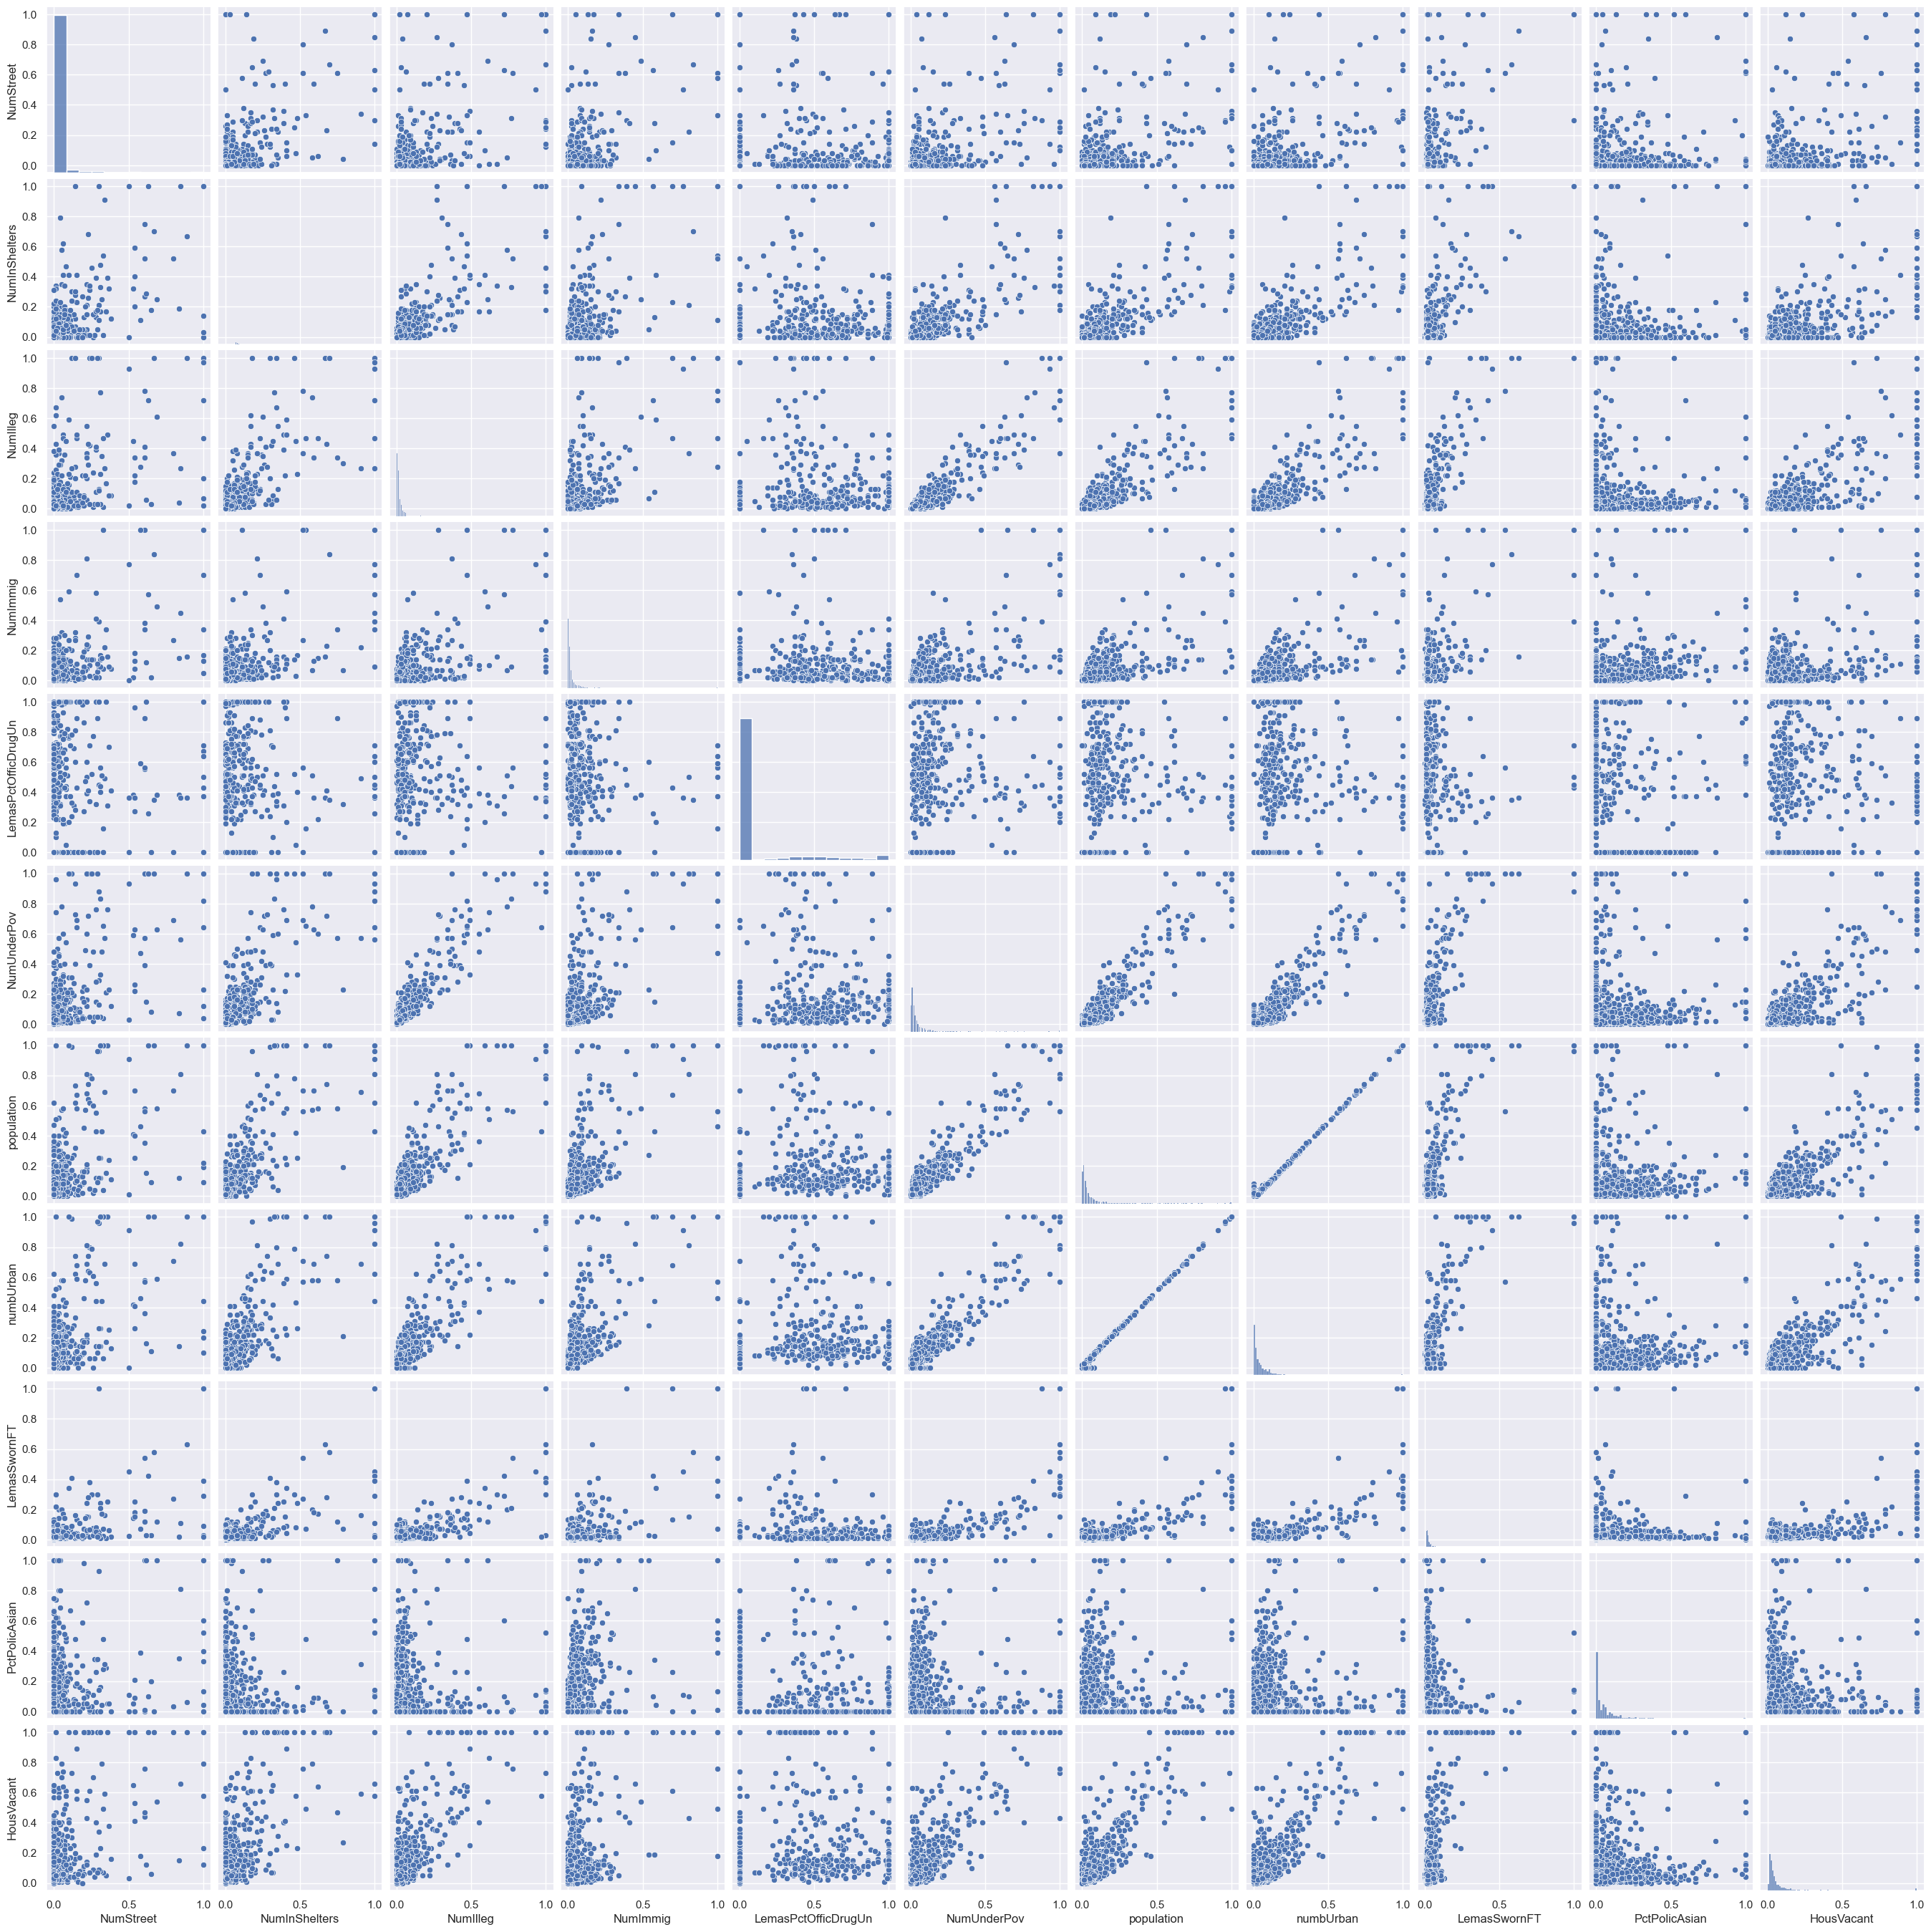

In [18]:
# sort the CVs in descending order
cv_list = sorted(cv_list, key=lambda x: x[1], reverse=True)

# get the features with highest CV
cv_columns = [x[0] for x in cv_list[:int(np.floor(np.sqrt(128)))]]
print("The features with highest CV are:", cv_columns)

# plot the features
sub_df = df_imputed.loc[:, cv_columns]
sns.set(style='darkgrid')
sns.pairplot(data=sub_df)
plt.show()

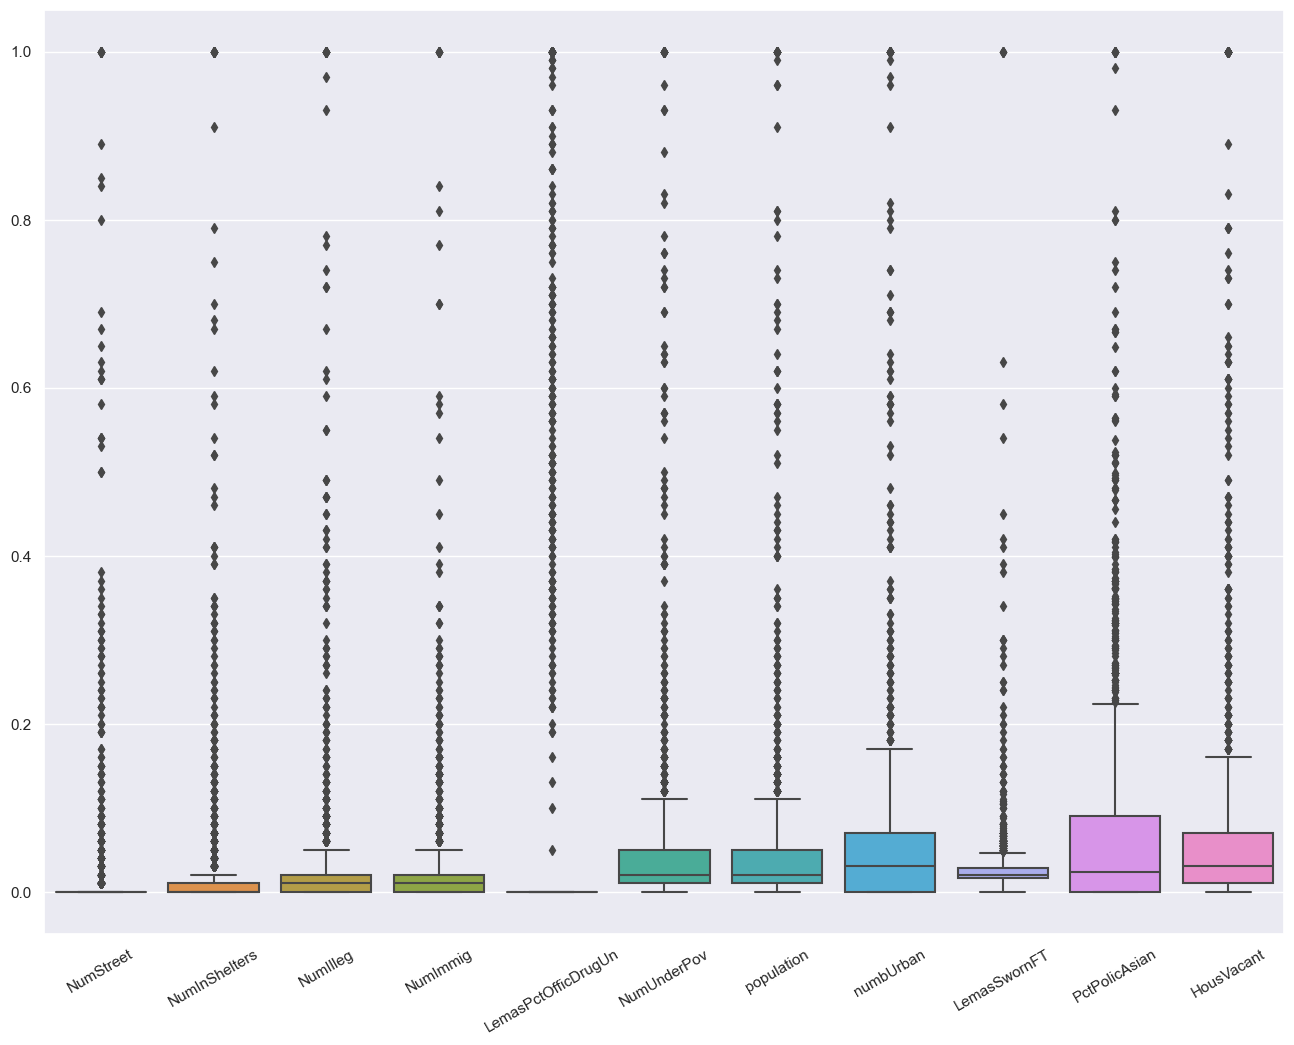

In [19]:
fig, axes = plt.subplots(figsize=(16, 12))
sns.boxplot(data=sub_df, ax=axes)
plt.xticks(rotation=30)
plt.show()

From the scatter plot, we can see that some features are highly correlated. When some features are highly correlated, it means that they are measuring similar or related aspects of the data. In terms of predicting results, it may indicate that both features are important and informative for making predictions, but it can also indicate that one of the features is redundant and can be removed without affecting the model's predictive accuracy. 

In general, highly correlated features can increase the risk of overfitting. This shows that feature selection techniques, such as principal component analysis or regularization, are needed in this case to identify and remove redundant or uninformative features while preserving the most important ones.

### (f) Fit a linear model

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# split train and test data
X_train = df_imputed.iloc[:1495,:-1]
y_train = df_imputed.iloc[:1495,-1]
X_test = df_imputed.iloc[1495:,:-1]
y_test = df_imputed.iloc[1495:,-1]
from sklearn.linear_model import Ridge
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
test_error = mean_squared_error(y_test, y_pred)
print('Test error for linear regression:', np.around(test_error,5))

Test error for linear regression: 0.01704


### (g) Fit a ridge regression model

In [5]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

ridge = Ridge()
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# perform a grid search cross-validation to find the best hyperparameters
grid = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)
best_model = grid.best_estimator_
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

test_error = mean_squared_error(y_test, y_pred)
print('Best Ridge parameter:', grid.best_estimator_)
print('Test error for Ridge regression:', np.around(test_error,5))

Best Ridge parameter: Ridge(alpha=1)
Test error for Ridge regression: 0.01697


### (h) Fit a LASSO model

First, we fit the Lasso model on non-standardized features.

In [6]:
from sklearn.linear_model import Lasso

lasso = Lasso()
param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(estimator=lasso, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)
best_model = grid.best_estimator_
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

test_error = mean_squared_error(y_test, y_pred)
print('Best Lasso parameter:', grid.best_estimator_)
print('Test error for Lasso regression:', np.around(test_error,5))

coef = best_model.coef_
selected_vars = [X_train.columns[i] for i in range(len(X_train.columns)) if coef[i] != 0]
print('Selected variables:', selected_vars)

Best Lasso parameter: Lasso(alpha=0.0001)
Test error for Lasso regression: 0.01715
Selected variables: ['racepctblack', 'racePctWhite', 'racePctAsian', 'racePctHisp', 'agePct12t21', 'agePct12t29', 'agePct65up', 'pctUrban', 'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'medFamInc', 'whitePerCap', 'blackPerCap', 'indianPerCap', 'AsianPerCap', 'OtherPerCap', 'HispPerCap', 'PctPopUnderPov', 'PctLess9thGrade', 'PctEmploy', 'PctEmplManu', 'PctEmplProfServ', 'MalePctDivorce', 'MalePctNevMarr', 'FemalePctDiv', 'PctKids2Par', 'PctYoungKids2Par', 'PctTeen2Par', 'PctWorkMomYoungKids', 'PctWorkMom', 'NumIlleg', 'PctIlleg', 'NumImmig', 'PctImmigRecent', 'PctImmigRec5', 'PctImmigRec10', 'PctRecImmig10', 'PctSpeakEnglOnly', 'PctNotSpeakEnglWell', 'PctLargHouseOccup', 'PersPerOccupHous', 'PctPersOwnOccup', 'PctPersDenseHous', 'PctHousLess3BR', 'HousVacant', 'PctHousOccup', 'PctVacantBoarded', 'PctVacMore6Mos', 'MedYrHousBuilt', 'PctHousNoPhone', 'PctWOFullPlumb',

Then, we fit the Lasso model on standardized features.

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_std = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_std = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

lasso = Lasso()
param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(estimator=lasso, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train_std, y_train)
best_model = grid.best_estimator_
best_model.fit(X_train_std, y_train)
y_pred = best_model.predict(X_test_std)

test_error = mean_squared_error(y_test, y_pred)
print('Best Lasso parameter:', grid.best_estimator_)
print('Test error for Lasso regression:', np.around(test_error,5))

coef = best_model.coef_
selected_vars = [X_train_std.columns[i] for i in range(len(X_train_std.columns)) if coef[i] != 0]
print('Selected variables:', selected_vars)

Best Lasso parameter: Lasso(alpha=0.001)
Test error for Lasso regression: 0.01738
Selected variables: ['racepctblack', 'racePctAsian', 'agePct12t21', 'agePct12t29', 'agePct65up', 'pctUrban', 'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'whitePerCap', 'blackPerCap', 'indianPerCap', 'AsianPerCap', 'OtherPerCap', 'HispPerCap', 'PctPopUnderPov', 'PctLess9thGrade', 'PctEmploy', 'PctEmplManu', 'MalePctDivorce', 'MalePctNevMarr', 'FemalePctDiv', 'PctKids2Par', 'PctYoungKids2Par', 'PctWorkMom', 'NumIlleg', 'PctIlleg', 'NumImmig', 'PctImmigRec5', 'PctImmigRec10', 'PctSpeakEnglOnly', 'PctLargHouseOccup', 'PctPersDenseHous', 'PctHousLess3BR', 'HousVacant', 'PctHousOccup', 'PctVacantBoarded', 'PctVacMore6Mos', 'MedYrHousBuilt', 'PctWOFullPlumb', 'RentLowQ', 'MedRent', 'MedRentPctHousInc', 'MedOwnCostPctInc', 'MedOwnCostPctIncNoMtg', 'NumInShelters', 'NumStreet', 'PctForeignBorn', 'PctSameCity85', 'LemasSwFTFieldPerPop', 'LemasTotalReq', 'PolicReqPerOffic', '

From the results we can see that unstandardized features perform a little better than standardized features. This my be because standardizing already normalized data may not be necessary, and may introduce additional noise or bias to the analysis or modeling results. But generally speaking, if we want to ensure that features have equal influence on the model fitting in LASSO or Ridge regression, we should standardize raw data.

### (i) Fit a PCR model

In [8]:
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

# Create a pipeline for modeling
pipeline = Pipeline([
    ('pca', PCA()),
    ('regressor', LinearRegression())
])

# Define a grid of M values to try
M_values = [i for i in range(1,123)]

# Use cross-validation to choose the best M value
cv_scores = []
for M in M_values:
    pipeline.set_params(pca__n_components=M)
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_scores.append(-scores.mean())

best_M = M_values[cv_scores.index(min(cv_scores))]
print("Best M value:", best_M)

pipeline.set_params(pca__n_components=best_M)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
test_error = mean_squared_error(y_test, y_pred)
print("Test error for PCR:", np.around(test_error,5))

Best M value: 97
Test error for PCR: 0.01767


### (j) Fit a boosting tree

In [12]:
import xgboost as xgb

model = xgb.XGBRegressor(objective='reg:squarederror')

param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(model, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)

best_alpha = grid.best_params_['alpha']
best_model = grid.best_estimator_
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
test_error = mean_squared_error(y_test, y_pred)

print('Best alpha:', best_alpha)
print('Test error for L1 penalized gradient boosting tree:', np.around(test_error,5))

Best alpha: 1
Test error for L1 penalized gradient boosting tree: 0.01676


Thus, we can conclude that L1 penalized gradient boosting tree has the best predictive performance.